In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


# Setting a professional aesthetic
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 8)

# Load dataset
df = pd.read_csv("train(1)(train(1)).csv")

# Quick check for data hygiene
print(f"Dataset Shape: {df.shape}")
print(f"Missing Values: {df.isnull().sum().sum()}")

Dataset Shape: (16209, 21)
Missing Values: 0


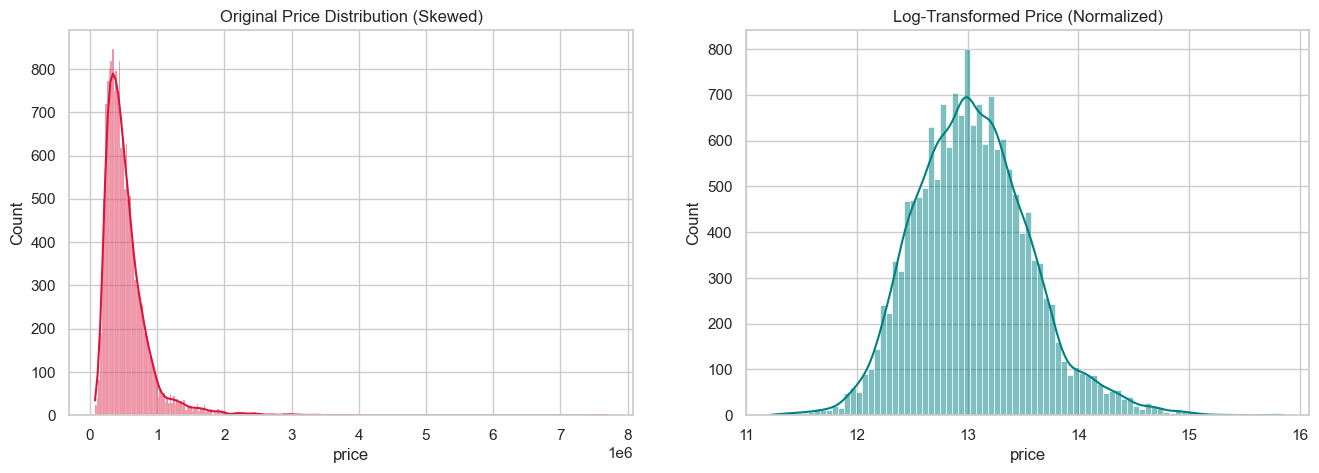

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(df['price'], kde=True, ax=ax[0], color='crimson')
ax[0].set_title('Original Price Distribution (Skewed)')

sns.histplot(np.log1p(df['price']), kde=True, ax=ax[1], color='teal')
ax[1].set_title('Log-Transformed Price (Normalized)')
plt.show()

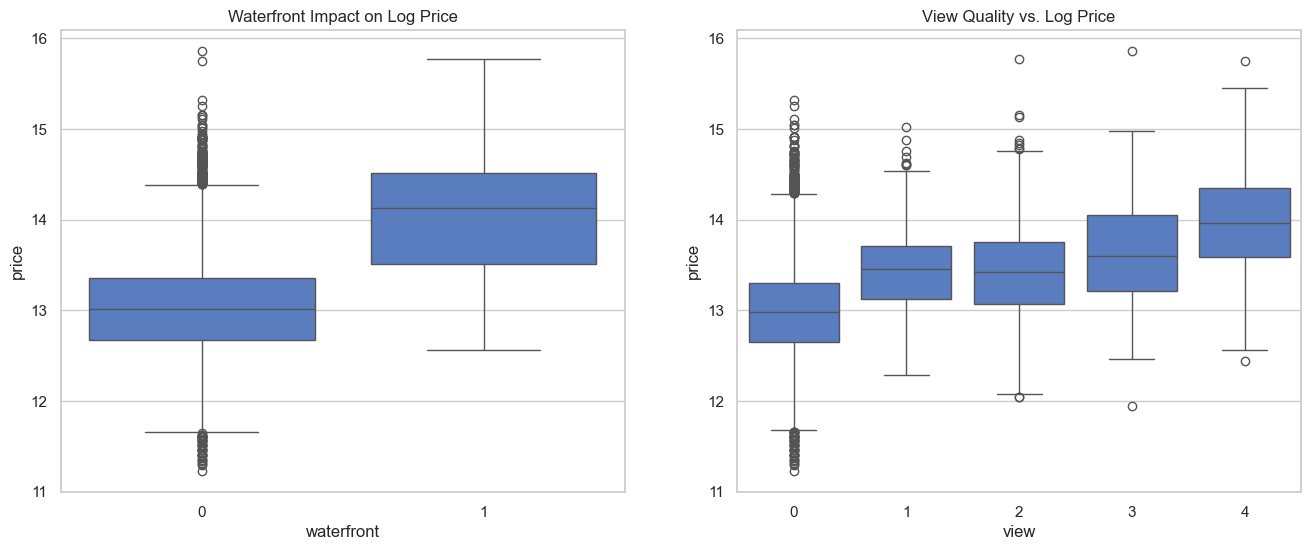

In [3]:
# Analyzing how 'View' and 'Waterfront' impact the median price
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(x='waterfront', y=np.log1p(df['price']), data=df, ax=ax[0])
ax[0].set_title('Waterfront Impact on Log Price')

sns.boxplot(x='view', y=np.log1p(df['price']), data=df, ax=ax[1])
ax[1].set_title('View Quality vs. Log Price')
plt.show()

In [4]:
def extract_features(data):
    df = data.copy()
    
    # 1. Temporal Engineering
    df['date'] = pd.to_datetime(df['date'])
    df['years_since_built'] = 2026 - df['yr_built']
    df['is_renovated'] = df['yr_renovated'].apply(lambda x: 1 if x > 0 else 0)
    
    # 2. Luxury & Space Ratios
    # Total square footage including basement
    df['total_living_area'] = df['sqft_living'] + df['sqft_basement']
    
    # Average room size (approximation)
    df['room_size_index'] = df['sqft_living'] / (df['bedrooms'] + df['bathrooms'] + 1)
    
    # 3. Neighborhood Context
    # How much larger/smaller is this house compared to its 15 nearest neighbors?
    df['neighbor_size_ratio'] = df['sqft_living'] / df['sqft_living15']
    
    # 4. Location Interaction
    # Distance from center-point (approximate center of high-value cluster)
    center_lat, center_lon = 47.62, -122.22
    df['dist_to_center'] = np.sqrt((df['lat'] - center_lat)**2 + (df['long'] - center_lon)**2)
    
    return df

df_enriched = extract_features(df)

In [5]:
# Calculate correlation with target
target_corr = df_enriched.corr()['price'].sort_values(ascending=False)

# Identify highly redundant features (sqft_above and sqft_living are often > 0.9 corr)
corr_matrix = df_enriched.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_redundant = [column for column in upper.columns if any(upper[column] > 0.95)]

# Final Selection
# Drop administrative IDs and redundant features
cols_to_exclude = ['id', 'date', 'zipcode', 'yr_built', 'yr_renovated'] + to_drop_redundant
final_df = df_enriched.drop(columns=cols_to_exclude)

print(f"Features retained for training: {final_df.columns.tolist()}")

Features retained for training: ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'total_living_area', 'room_size_index', 'neighbor_size_ratio', 'dist_to_center']


In [6]:
# Log transform all 'sqft' columns to handle outliers
sqft_cols = [col for col in final_df.columns if 'sqft' in col]
for col in sqft_cols:
    final_df[f'log_{col}'] = np.log1p(final_df[col])
    final_df.drop(columns=[col], inplace=True)

# Final target log transform
final_df['log_price'] = np.log1p(final_df['price'])
final_df.drop(columns=['price'], inplace=True)

final_df.to_csv("transformed_tabular_v2.csv", index=False)
print("✅ Preprocessing & Feature Extraction Complete!")

✅ Preprocessing & Feature Extraction Complete!


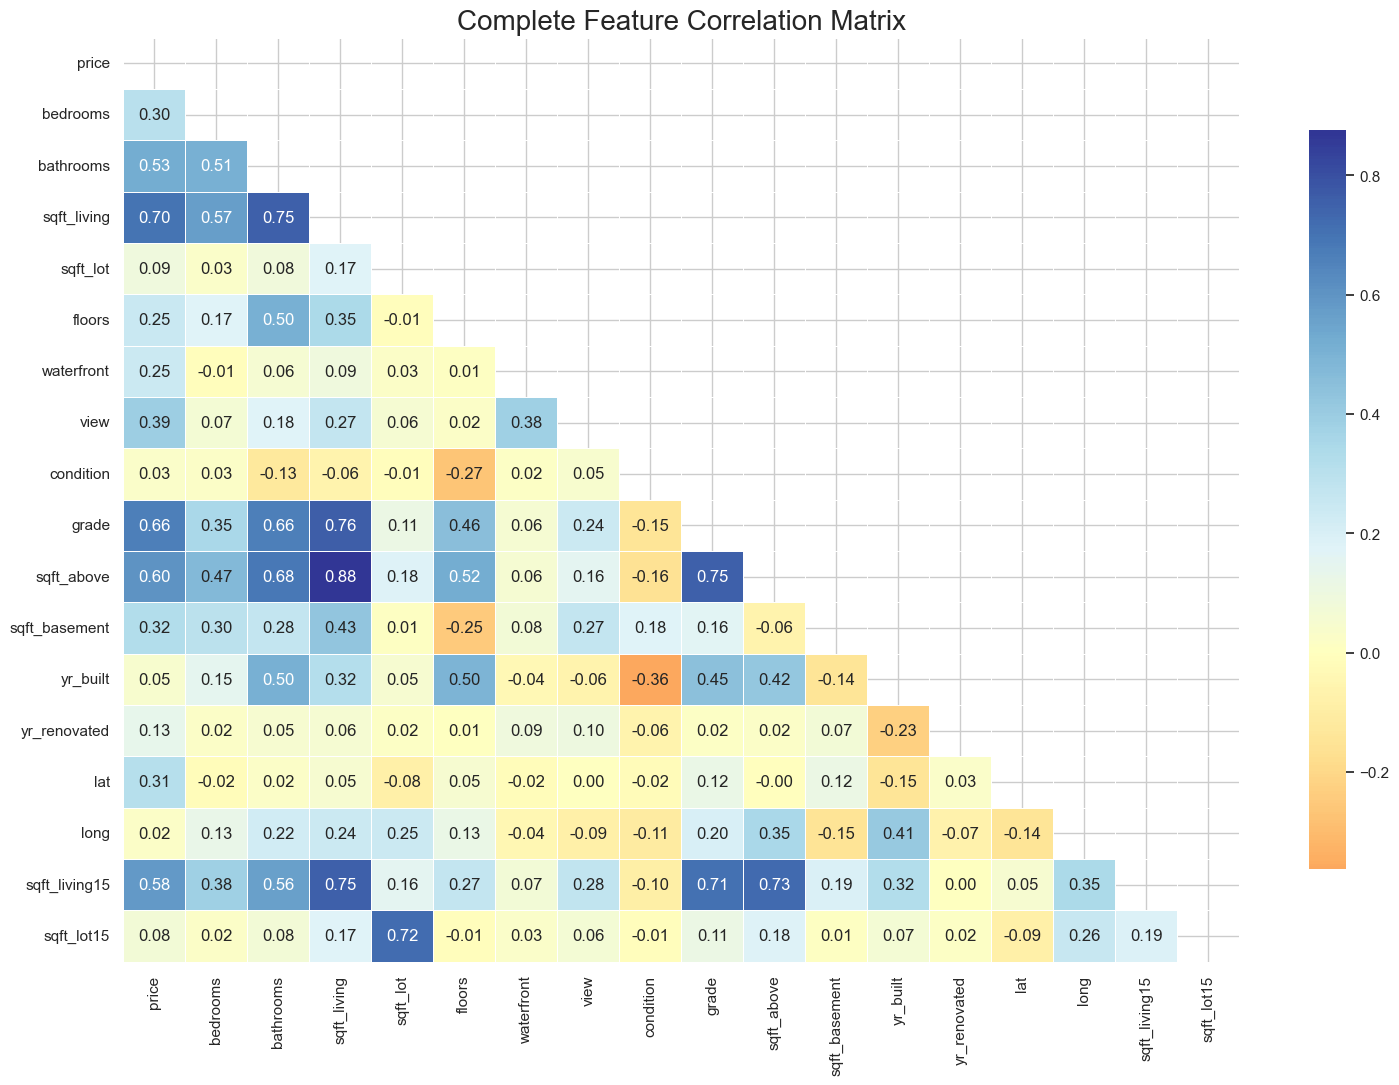

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Increase figure size to accommodate all columns
plt.figure(figsize=(18, 12))

# Select numeric columns (excluding ID and Zipcode for clarity)
full_corr = df.select_dtypes(include=[np.number]).drop(columns=['id', 'zipcode'], errors='ignore').corr()

# Create a mask to show only the lower triangle (cleaner look)
mask = np.triu(np.ones_like(full_corr, dtype=bool))

sns.heatmap(full_corr, mask=mask, annot=True, fmt=".2f", cmap='RdYlBu', center=0, 
            linewidths=.5, cbar_kws={"shrink": .8})
plt.title('Complete Feature Correlation Matrix', fontsize=20)
plt.show()


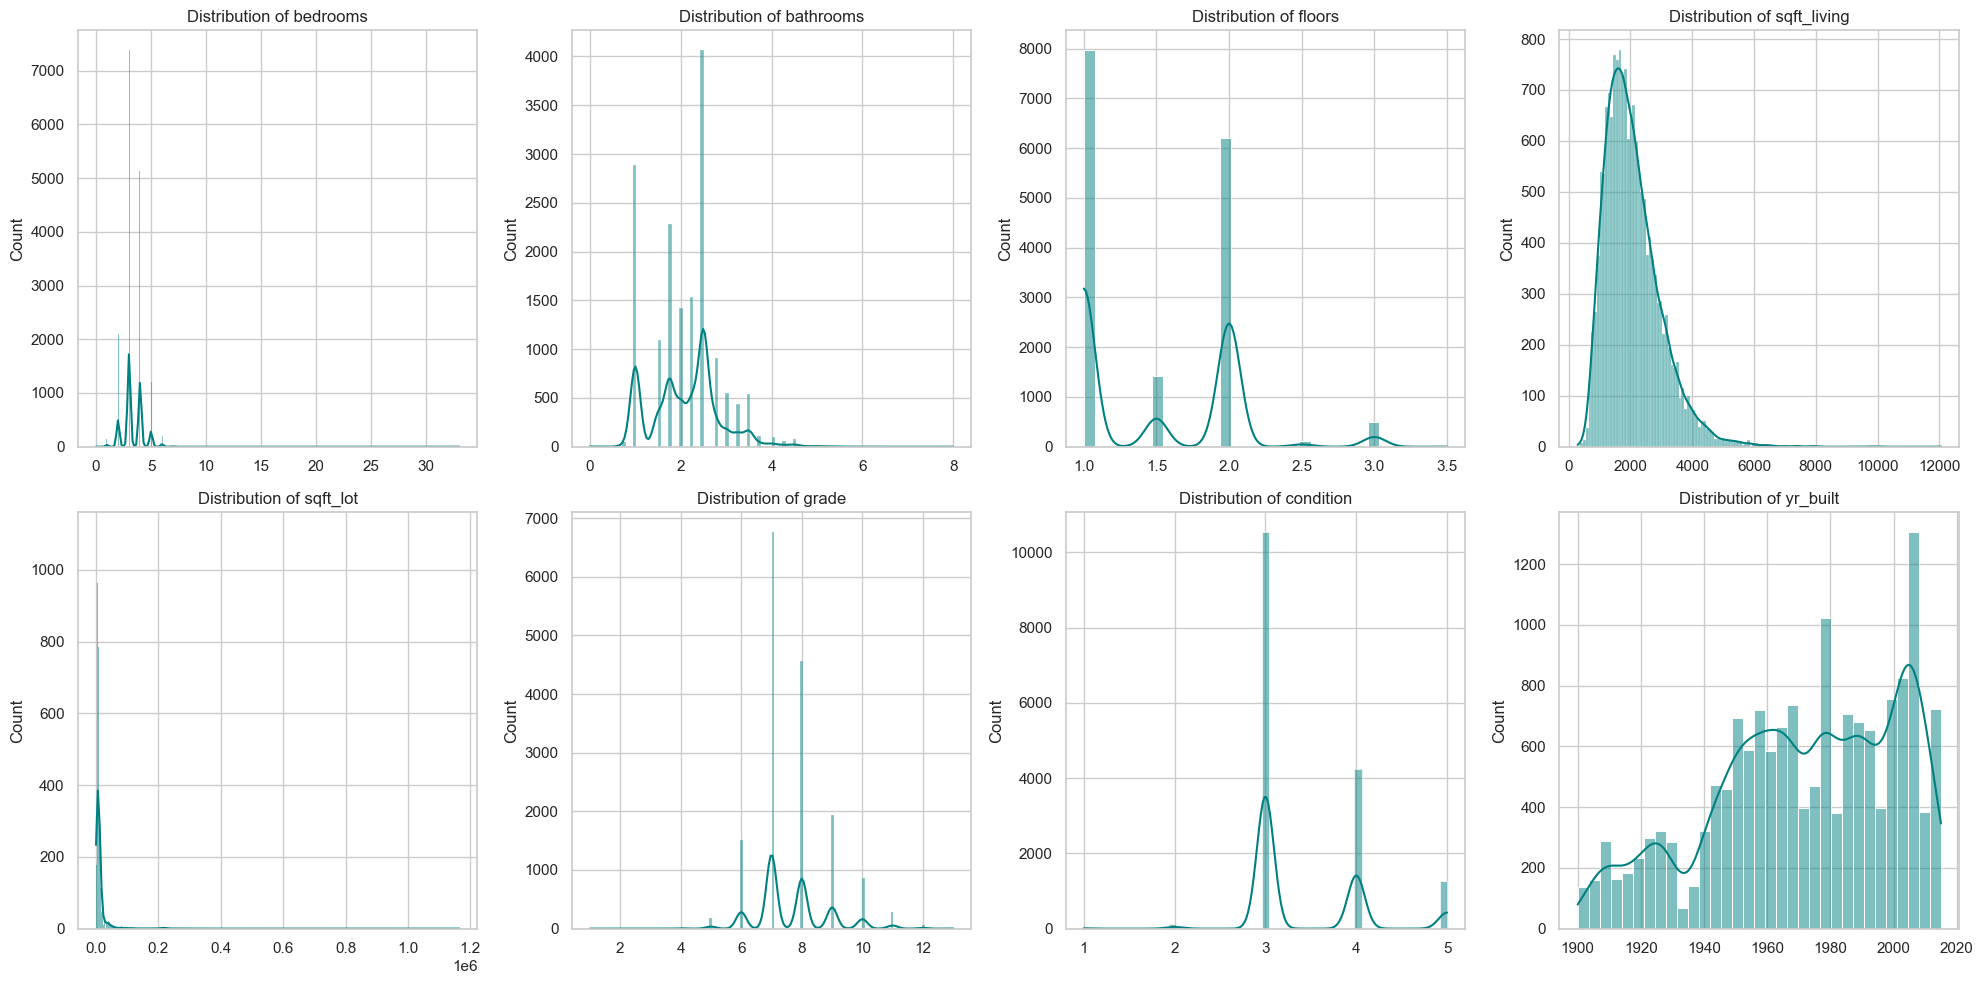

In [8]:
# Plotting distributions for 8 key columns at once
cols_to_plot = ['bedrooms', 'bathrooms', 'floors', 'sqft_living', 'sqft_lot', 'grade', 'condition', 'yr_built']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    sns.histplot(df[col], kde=True, ax=axes[i], color='teal')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('')

plt.tight_layout()
plt.show()

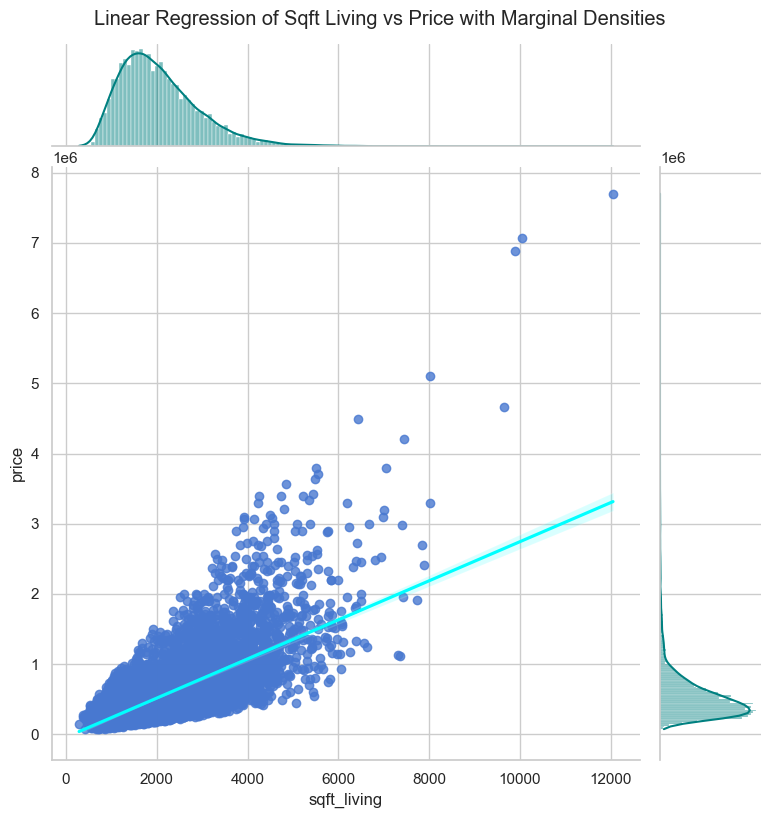

In [9]:
# Relationship between Construction Grade, Sqft Living and Price
g = sns.jointplot(data=df, x='sqft_living', y='price', kind='reg', 
                  joint_kws={'line_kws':{'color':'cyan'}}, 
                  marginal_kws={'color':'teal'}, height=8)
g.fig.suptitle('Linear Regression of Sqft Living vs Price with Marginal Densities', y=1.02)
plt.show()

C:\Users\aksha\AppData\Local\Temp\ipykernel_24272\841764582.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='view', y='price', data=df, palette='Set2')
C:\Users\aksha\AppData\Local\Temp\ipykernel_24272\841764582.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='condition', y='price', data=df, palette='Pastel1')


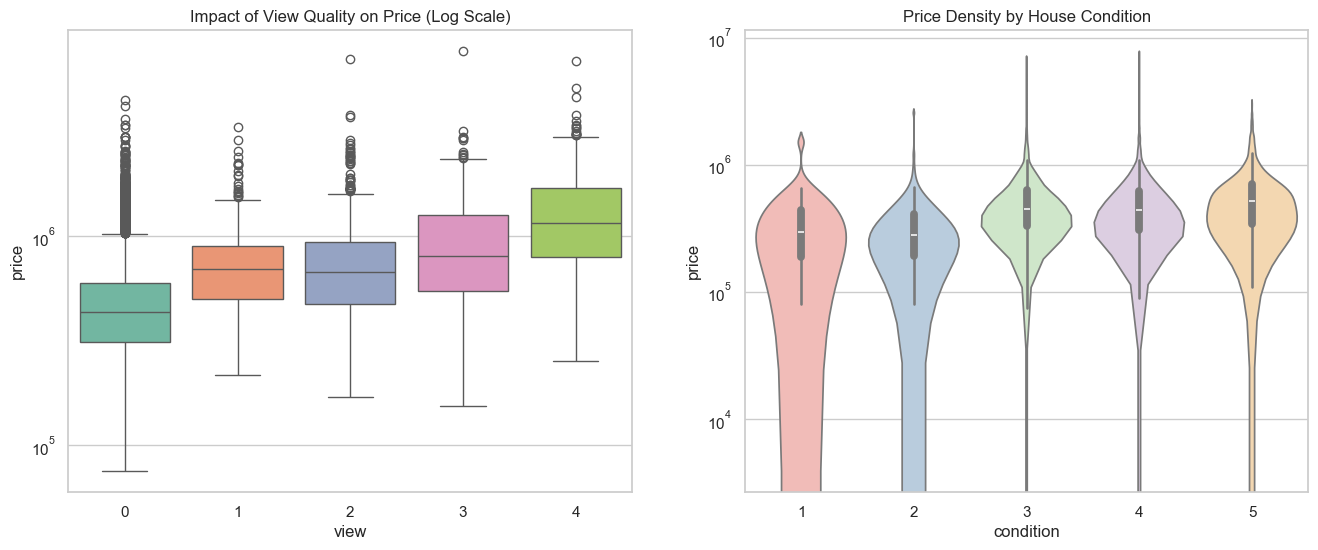

In [10]:
plt.figure(figsize=(16, 6))

# Subplot 1: Price across Views
plt.subplot(1, 2, 1)
sns.boxplot(x='view', y='price', data=df, palette='Set2')
plt.yscale('log')
plt.title('Impact of View Quality on Price (Log Scale)')

# Subplot 2: Price across Conditions
plt.subplot(1, 2, 2)
sns.violinplot(x='condition', y='price', data=df, palette='Pastel1')
plt.yscale('log')
plt.title('Price Density by House Condition')

plt.show()

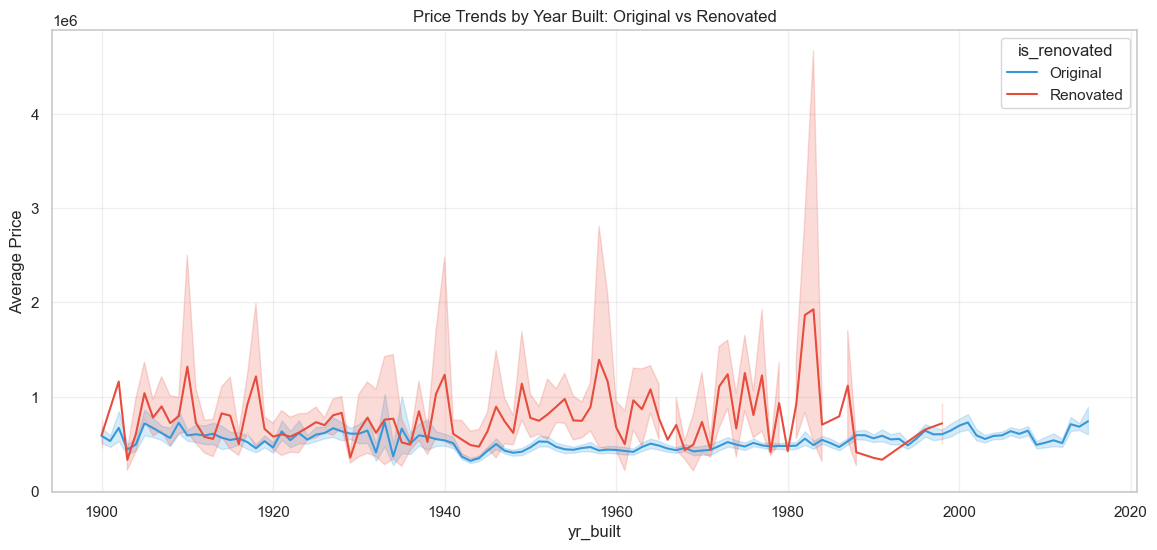

In [11]:
# Creating an 'is_renovated' helper column for the plot
df['is_renovated'] = df['yr_renovated'].apply(lambda x: 'Renovated' if x > 0 else 'Original')

plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='yr_built', y='price', hue='is_renovated', palette=['#3498db', '#e74c3c'])
plt.title('Price Trends by Year Built: Original vs Renovated')
plt.ylabel('Average Price')
plt.grid(True, alpha=0.3)
plt.show()

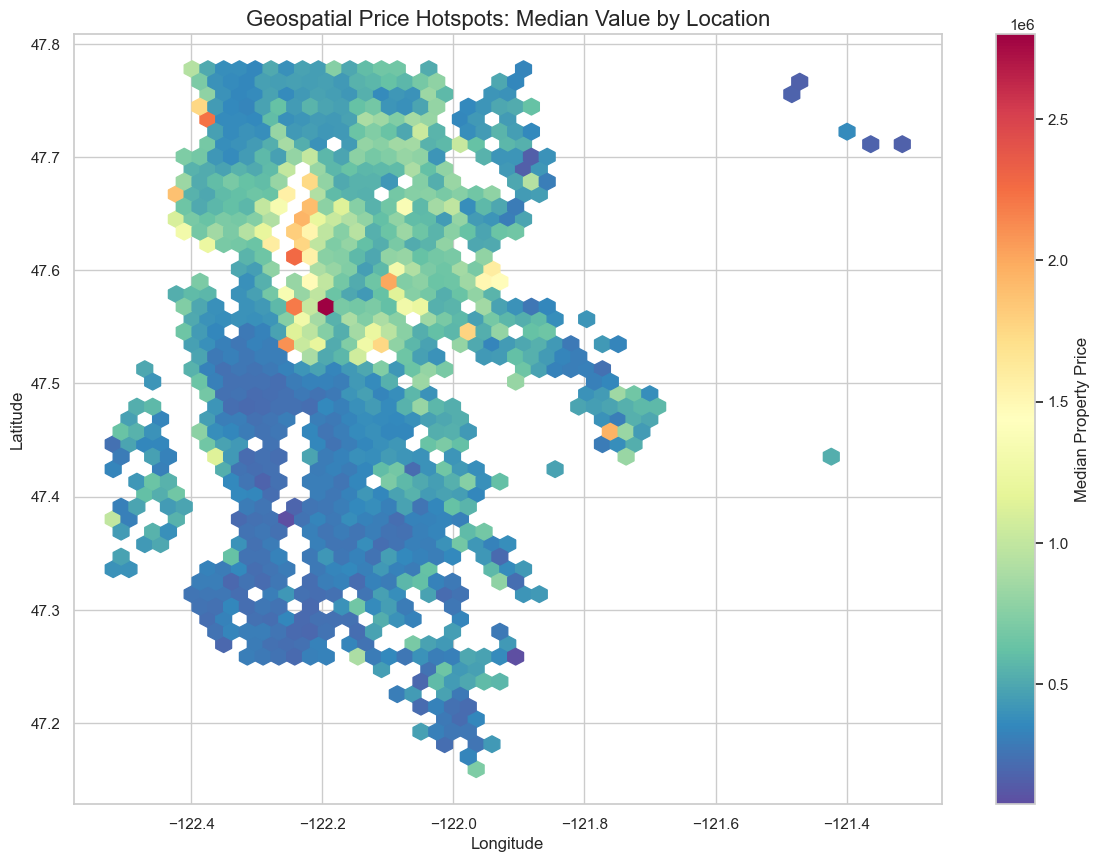

In [12]:
plt.figure(figsize=(14, 10))
hb = plt.hexbin(df['long'], df['lat'], C=df['price'], gridsize=50, 
                cmap='Spectral_r', reduce_C_function=np.median, mincnt=1)
cb = plt.colorbar(hb)
cb.set_label('Median Property Price')
plt.title('Geospatial Price Hotspots: Median Value by Location', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

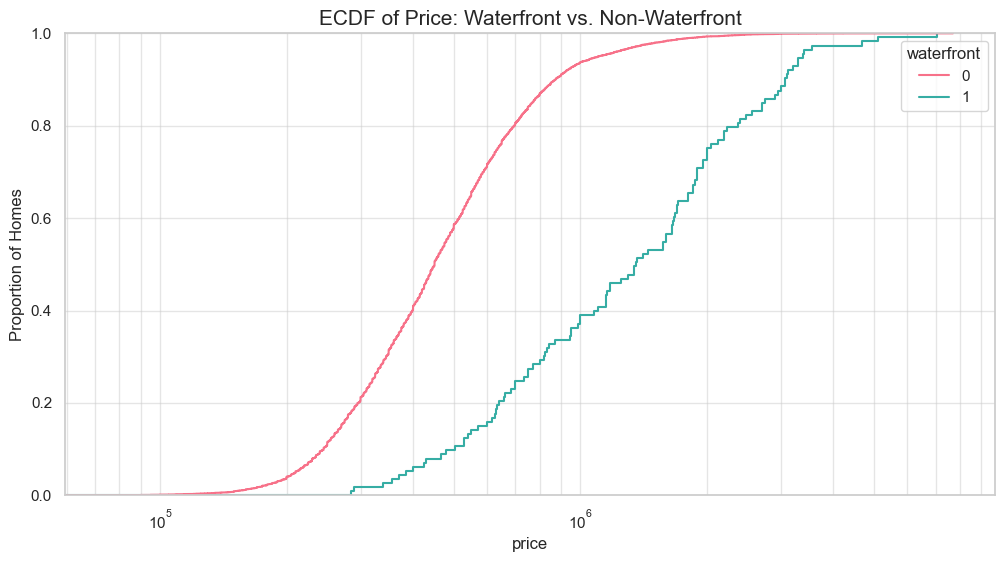

In [13]:
plt.figure(figsize=(12, 6))
sns.ecdfplot(data=df, x="price", hue="waterfront", palette="husl")
plt.title('ECDF of Price: Waterfront vs. Non-Waterfront', fontsize=15)
plt.xscale('log')
plt.ylabel('Proportion of Homes')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()


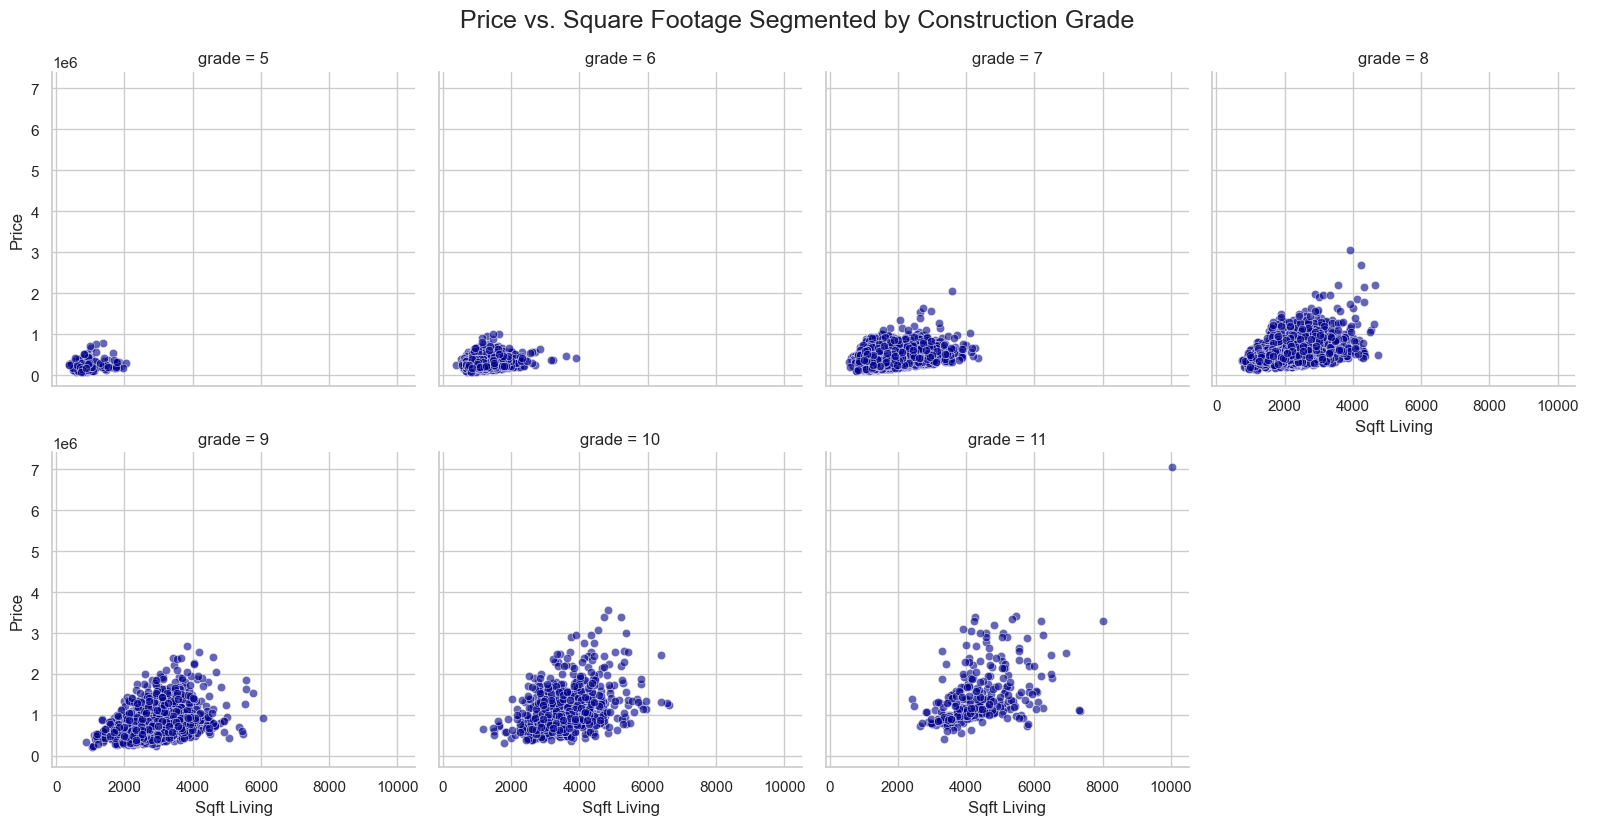

In [14]:
# We filter for the most common grades (5 to 11) to keep the plot clean
subset_df = df[df['grade'].between(5, 11)]

g = sns.FacetGrid(subset_df, col="grade", col_wrap=4, height=4, aspect=1)
g.map_dataframe(sns.scatterplot, x="sqft_living", y="price", alpha=0.6, color="darkblue")
g.set_axis_labels("Sqft Living", "Price")
g.add_legend()
g.fig.suptitle('Price vs. Square Footage Segmented by Construction Grade', y=1.03, fontsize=18)
plt.show()

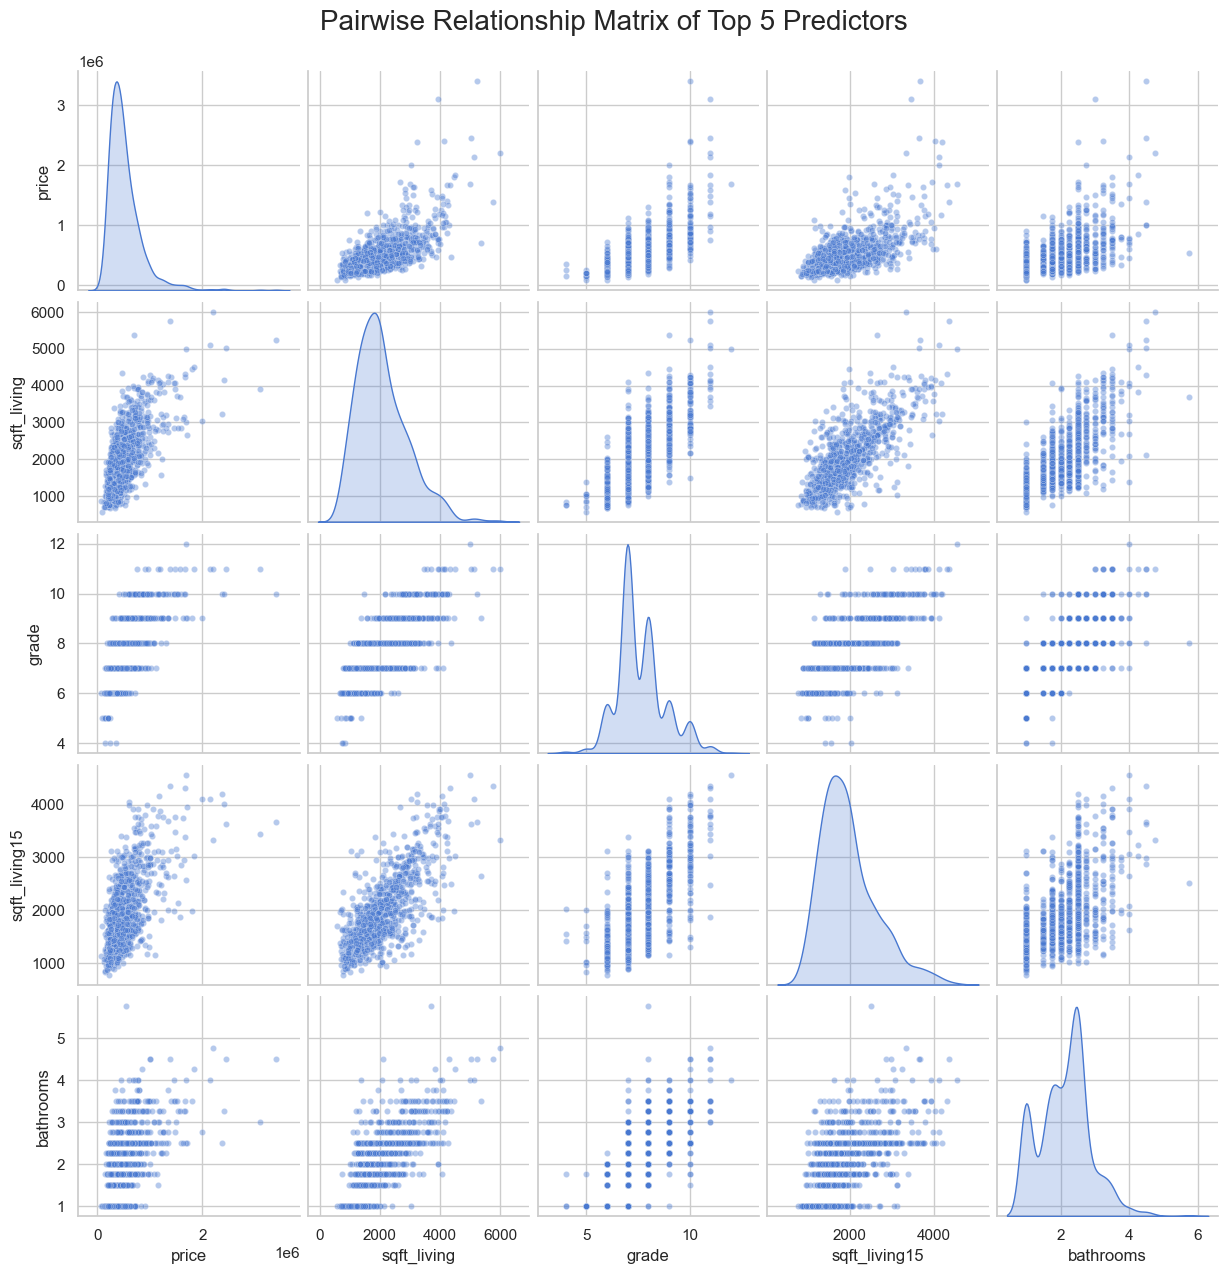

In [16]:
# Selecting top 5 most predictive features for a clean grid
top_5_cols = ['price', 'sqft_living', 'grade', 'sqft_living15', 'bathrooms']

# Sampling 1000 points to keep the render fast while showing patterns
sns.pairplot(df[top_5_cols].sample(1000), diag_kind='kde', plot_kws={'alpha':0.4, 's':20, 'edgecolor':'w'})
plt.suptitle('Pairwise Relationship Matrix of Top 5 Predictors', y=1.02, fontsize=20)
plt.show()

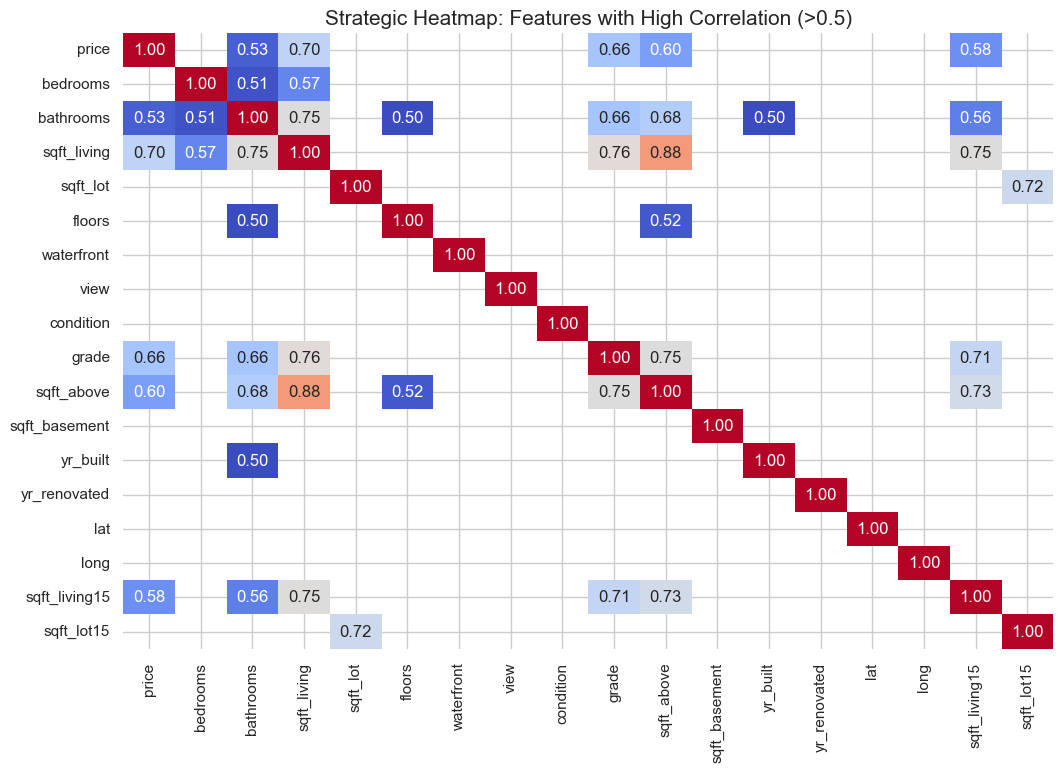

In [17]:
plt.figure(figsize=(12, 8))
high_corr = full_corr[abs(full_corr) > 0.5]
sns.heatmap(high_corr, annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
plt.title('Strategic Heatmap: Features with High Correlation (>0.5)', fontsize=15)
plt.show()


In [1]:
import numpy as np
import torch

print("NumPy:", np.__version__)
print("Torch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())


NumPy: 1.26.4
Torch: 2.1.2
CUDA: True
